In [1]:
import pandas as pd
import numpy as np

In [2]:
#Load common functions
import ipynb.fs.full.common as common

In [3]:
MML_VARIABLE_ANALYZED = 'POP'
REGION = "LAM"

In [4]:
df = pd.read_excel('data/UN-AnnualTotPopMidYear-20220717021110.xlsx', sheet_name='Data')
#Annual Total Population at Mid-Year (thousands)
df[0:5]

,ISO 3166-1 numeric code,Location,Note,1960,1962,1964,1966,1968,1970,1972,...,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020
0,900,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,904,Latin America and the Caribbean,NaN,221051.0,233538.0,246673.0,260149.0,273914.0,288077.0,302686.0,...,540354.0,554541.0,568819.0,583222.0,597562.0,611714.0,625594.0,639049.0,652012.0,664474.0
2,915,Caribbean,NaN,20723.0,21643.0,22610.0,23539.0,24419.0,25310.0,26244.0,...,39114.0,39787.0,40442.0,41084.0,41725.0,42371.0,43006.0,43602.0,44155.0,44679.0
3,660,Anguilla,NaN,6.0,6.0,6.0,6.0,6.0,6.0,7.0,...,12.0,12.0,13.0,13.0,14.0,14.0,14.0,15.0,15.0,15.0
4,28,Antigua and Barbuda,NaN,55.0,57.0,60.0,62.0,65.0,67.0,69.0,...,86.0,88.0,90.0,92.0,95.0,97.0,99.0,101.0,103.0,105.0


In [5]:
del df['ISO 3166-1 numeric code']
del df['Note']
df.columns = df.columns.astype(str)
df['Location'] = df['Location'].str.strip()
df[0:5]

,Location,1960,1962,1964,1966,1968,1970,1972,1974,1976,...,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020
0,World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Latin America and the Caribbean,221051.0,233538.0,246673.0,260149.0,273914.0,288077.0,302686.0,317667.0,332930.0,...,540354.0,554541.0,568819.0,583222.0,597562.0,611714.0,625594.0,639049.0,652012.0,664474.0
2,Caribbean,20723.0,21643.0,22610.0,23539.0,24419.0,25310.0,26244.0,27186.0,28081.0,...,39114.0,39787.0,40442.0,41084.0,41725.0,42371.0,43006.0,43602.0,44155.0,44679.0
3,Anguilla,6.0,6.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,...,12.0,12.0,13.0,13.0,14.0,14.0,14.0,15.0,15.0,15.0
4,Antigua and Barbuda,55.0,57.0,60.0,62.0,65.0,67.0,69.0,71.0,72.0,...,86.0,88.0,90.0,92.0,95.0,97.0,99.0,101.0,103.0,105.0


In [6]:
print("Missing countries for region")
print(common.get_missing_countries_for_region(df, 'Location', REGION))
#Actually, they are not missing, they have a different value
df.loc[df.Location == 'Venezuela (Bolivarian Republic of)', 'Location'] = 'Venezuela'
df.loc[df.Location == 'Bolivia (Plurinational State of)', 'Location'] = 'Bolivia'
print("Missing countries for region after fix")
print(common.get_missing_countries_for_region(df, 'Location'))

Missing countries for region
{'Venezuela', 'Bolivia'}
Missing countries for region after fix
set()


In [7]:
df_truth = common.get_countries_for_region(df, 'Location', REGION)
assert len(df_truth) == len(common.regions[REGION]['countries']), 'MISSING COUNTRIES FOR REGION'

In [8]:
years_filtered = np.arange(1970,2020,2) 
columns_filter = np.append(['Location'],years_filtered)

df_truth = df_truth[columns_filter]
assert 0 == df_truth.isna().sum().sum(), "MISSING VALUES. CONSIDER FILL STRATEGY" #If 0, then we don't have missing values.

Finally, we got our truth dataframe. Now, MML

In [9]:
df_mml = common.get_mml_data()
df_mml = df_mml[['Year',MML_VARIABLE_ANALYZED]]
df_mml = df_mml[df_mml.Year <= 2020]
# According to truth dataset, population values are expressed in thousands, so 1 in truth is actually 1000.
df_mml[MML_VARIABLE_ANALYZED] = df_mml[MML_VARIABLE_ANALYZED] / 1000 
df_mml[0:3]

,Year,POP
0,1960,208400.0
1,1962,219700.0
2,1964,231600.0


Ok, that was easy. Back to truth df. 
We need to transpose df, get only even years and group by some condition

In [10]:
df_T = df_truth.set_index('Location').T
df_T = df_T.reset_index().rename(columns={"index": "Year"})


df_truth = df_T.astype({'Year': 'int64'})
df_truth['sum'] = df_truth.iloc[:, 1:len(common.regions[REGION]['countries'])+1].sum(axis=1)
df_truth_aggs = df_truth[['Year','sum']]

In [11]:
df = pd.merge(df_mml,df_truth_aggs,on='Year').rename(columns={"POP": "mml_value", "sum":"truth_value"})
df[0:3]

,Year,mml_value,truth_value
0,1970,271500.0,282269.0
1,1972,286000.0,296735.0
2,1974,301300.0,311568.0


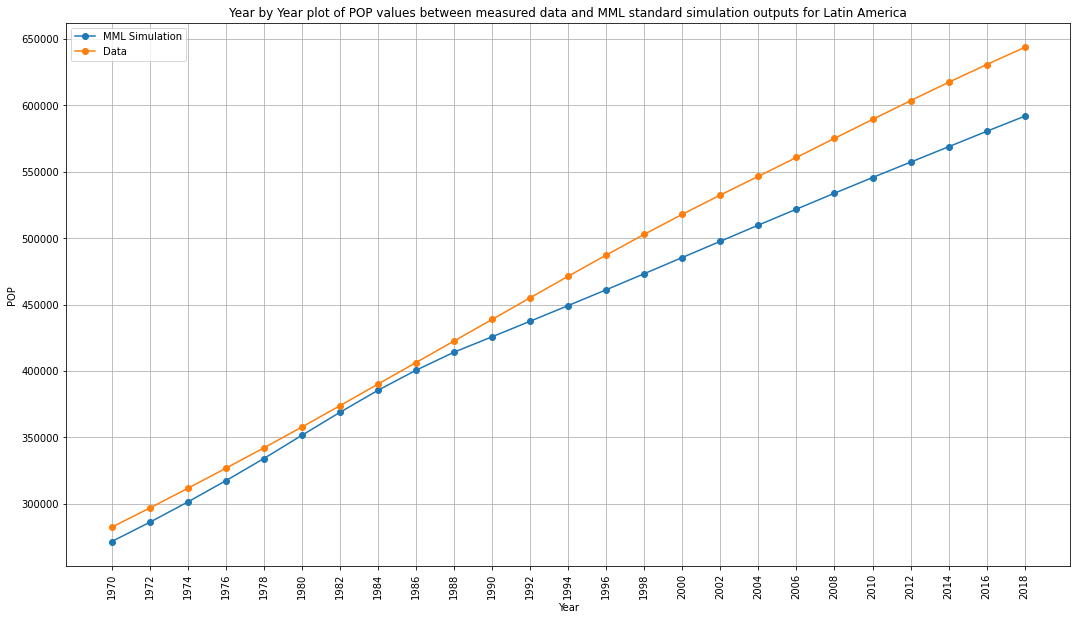

In [12]:

common.compare_mml_vs_truth_line_plot(df, 'Year', 'mml_value', 'truth_value', MML_VARIABLE_ANALYZED, REGION)

As we see in the graph, from 1988, mml stops growing as the truth continues the original tendence.

### 1970 - 1988

So, let's take only from 1970-1988

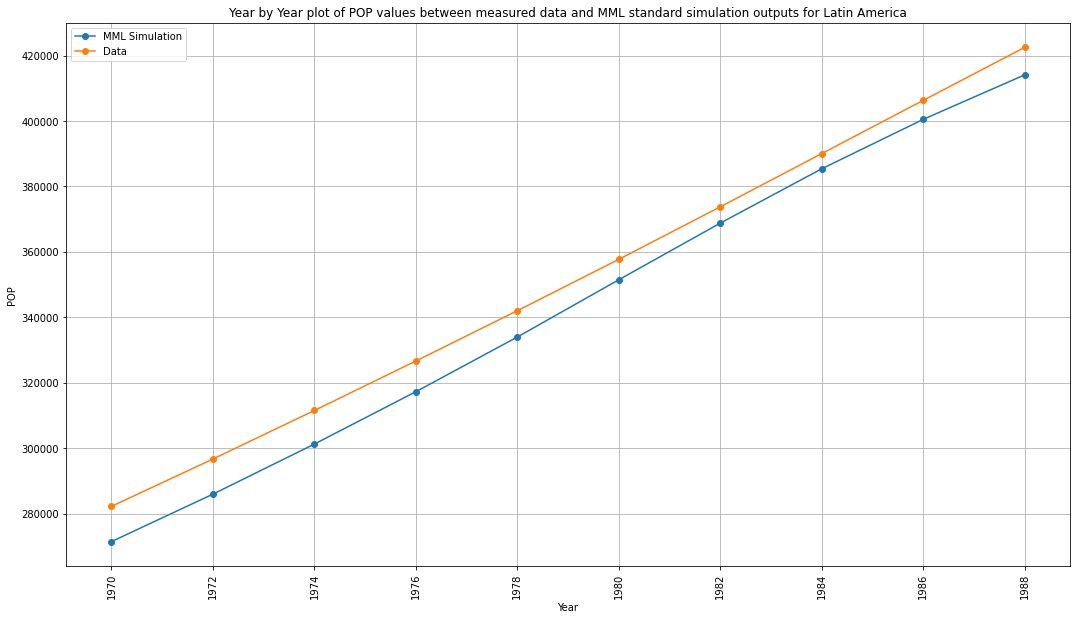

In [13]:
df_1988 = df[df['Year']<=1988]
common.compare_mml_vs_truth_line_plot(df_1988, 'Year', 'mml_value', 'truth_value', MML_VARIABLE_ANALYZED, REGION)

Mean seems to be quite accurate in that interval

### Error visualization

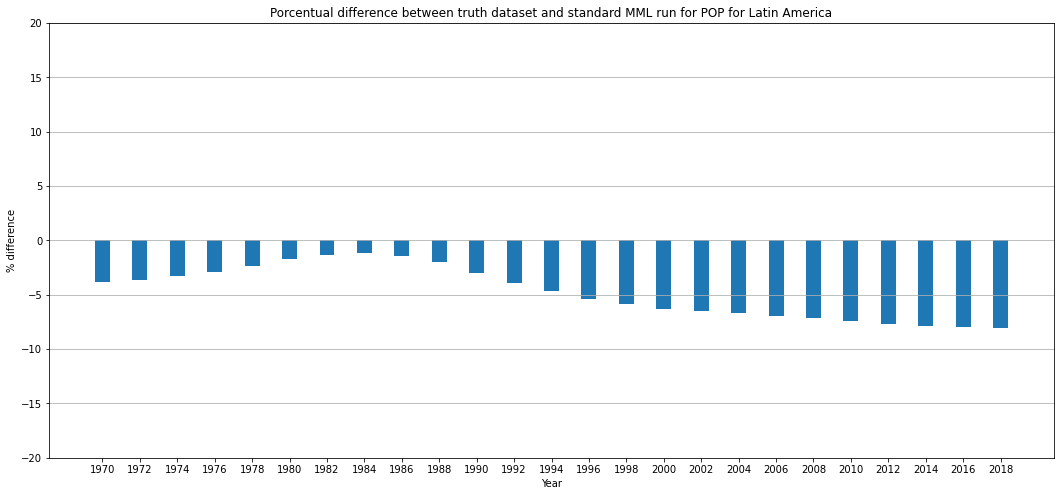

In [14]:
common.compute_porcentual_diff_between_truth_and_mml(df, 'mml_value', 'truth_value')
common.porcentual_diff_plot(df,MML_VARIABLE_ANALYZED, REGION, years_filtered, np.arange(-20,21,5))

In [15]:
common.save_porcentual_diff_to_excel_for_variable(df, MML_VARIABLE_ANALYZED)